TODO:
Solve a heat equation. Get a good general function that solves a general diffusion equation. (abstract away grid, use crank-nicolson)

Converged after 89 iterations.


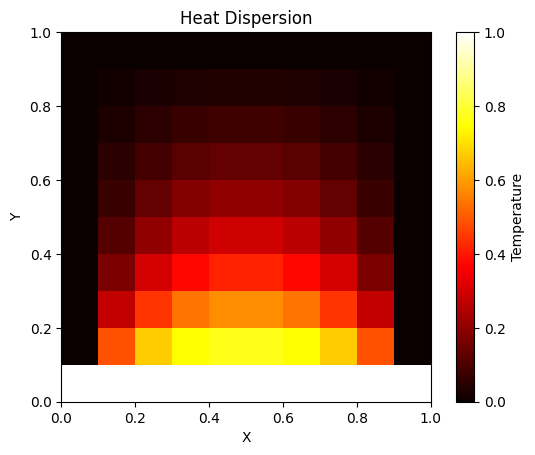

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
N = 10  # Number of grid points in each dimension
tolerance = 1e-4  # Convergence tolerance
max_iterations = 10000  # Maximum number of iterations

# Initialize grid with zeros
grid = np.zeros((N, N))

# Apply boundary conditions
grid[0, :] = 1  # Top boundary

# Create a copy of the grid to store the updated values
new_grid = np.copy(grid)

# Jacobi iteration
for iteration in range(max_iterations):
    for i in range(1, N - 1):
        for j in range(1, N - 1):
            new_grid[i, j] = 0.25 * (grid[i+1, j] + grid[i-1, j] + grid[i, j+1] + grid[i, j-1])

    # Check for convergence
    if np.max(np.abs(new_grid - grid)) < tolerance:
        print(f"Converged after {iteration + 1} iterations.")
        break

    # Update grid with new values
    grid[:] = new_grid

else:
    print("Warning: Maximum number of iterations reached without convergence.")

# Plot the result
plt.imshow(grid, cmap='hot', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar(label='Temperature')
plt.title('Heat Dispersion')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


/var/folders/v4/lff3q_kx5fd_t751bv557yvr0000gn/T/ipykernel_52610/1831647157.py:43: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  grid = spsolve(A, b).reshape((N, N))


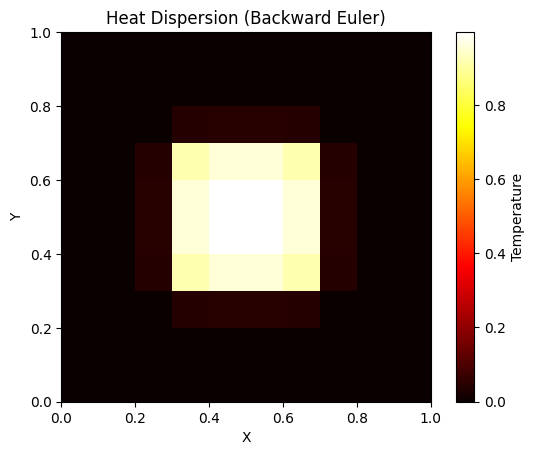

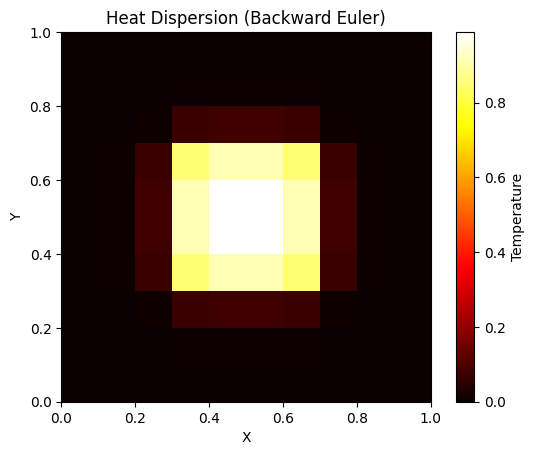

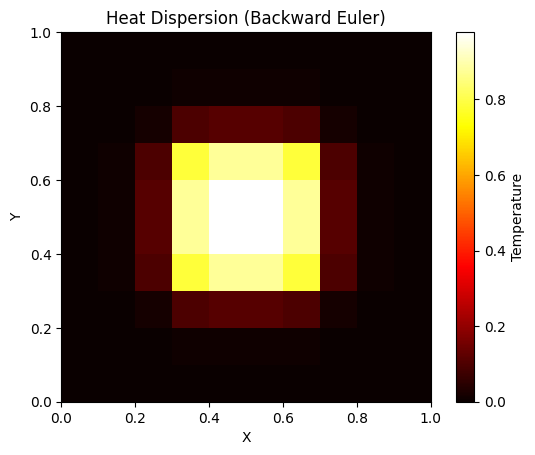

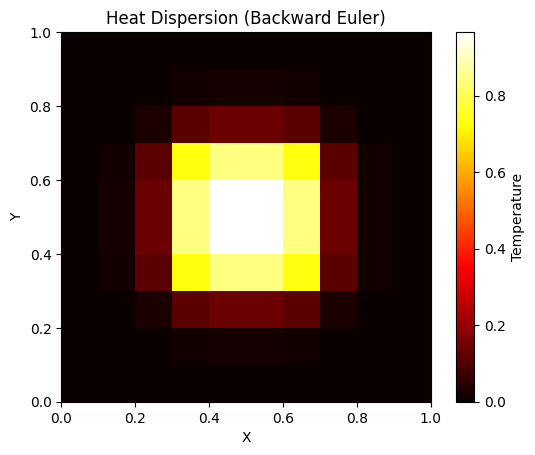

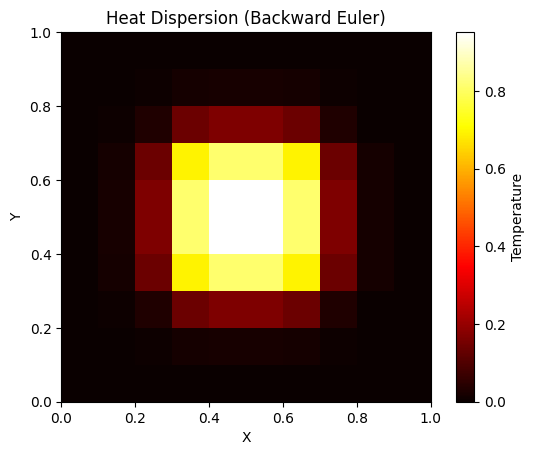

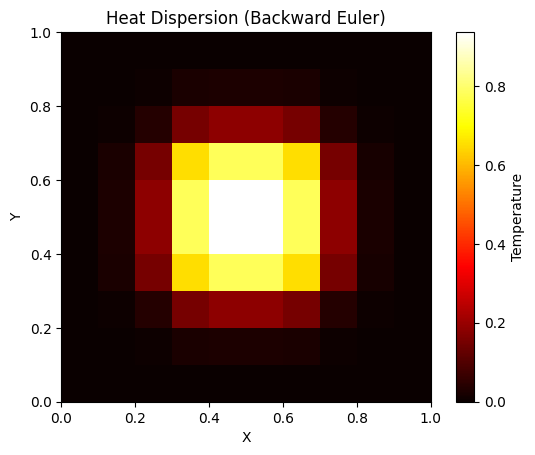

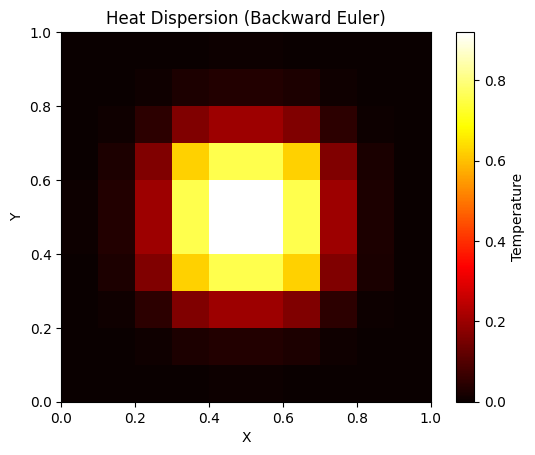

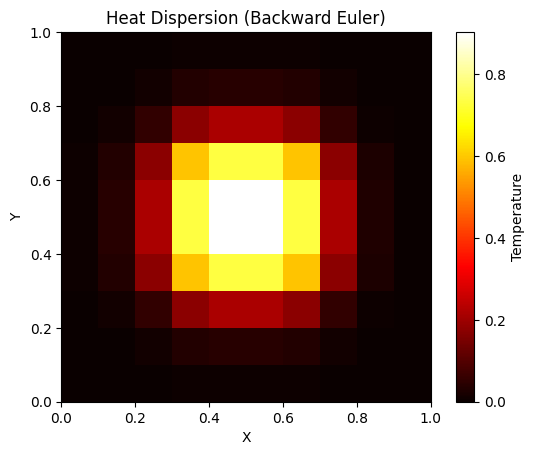

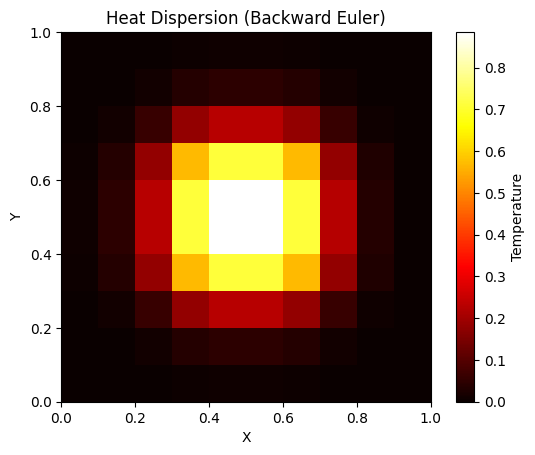

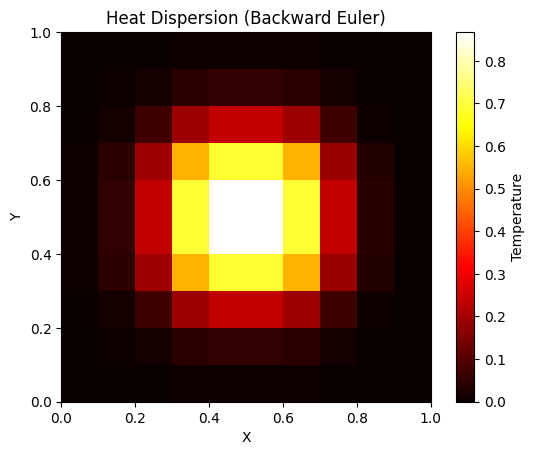

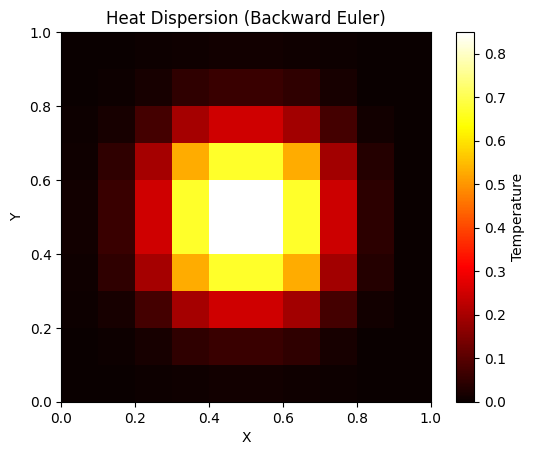

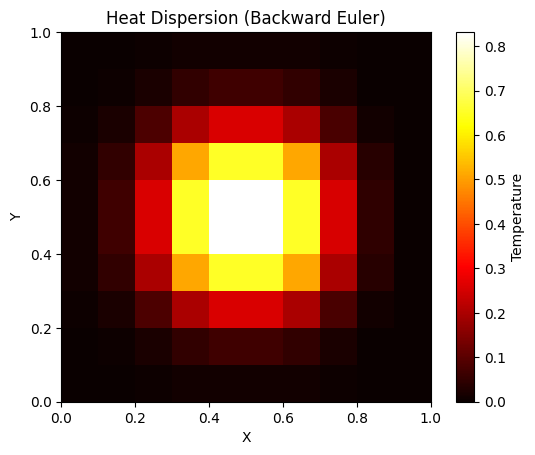

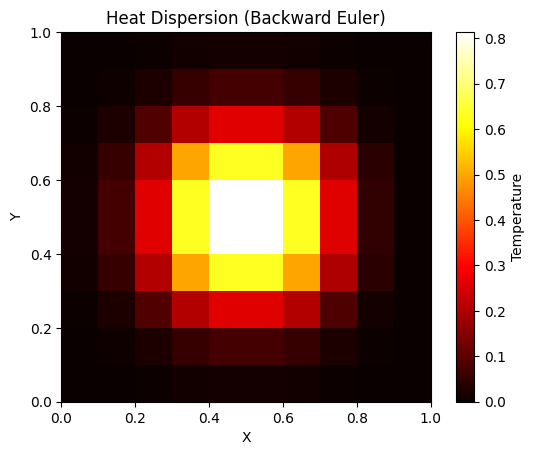

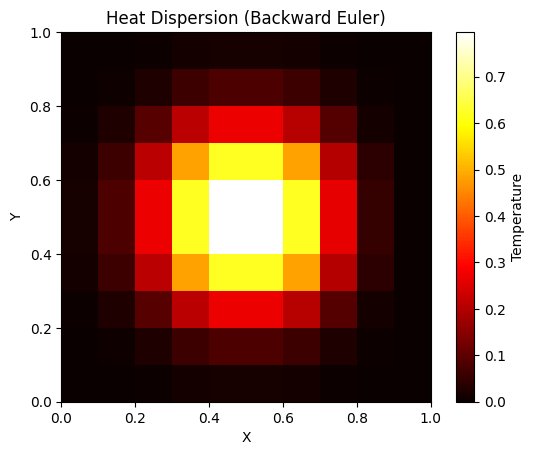

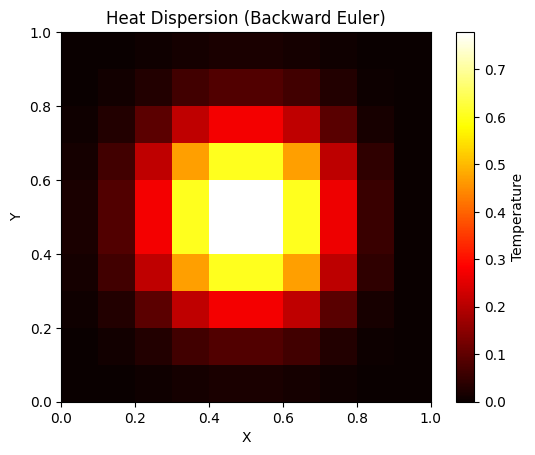

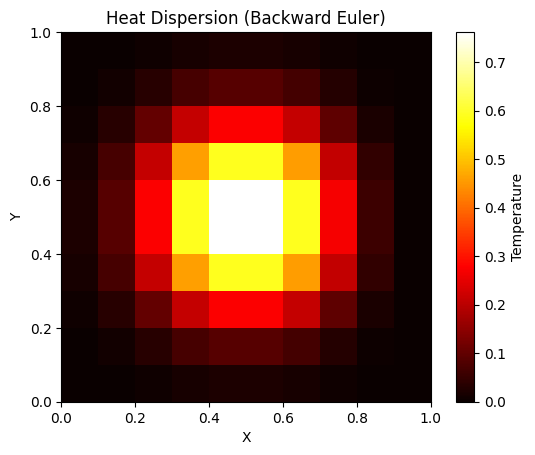

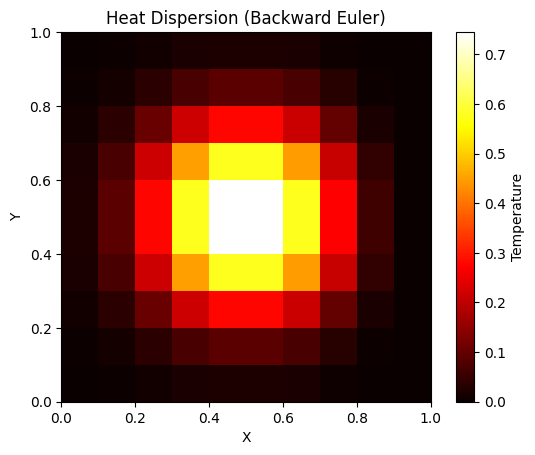

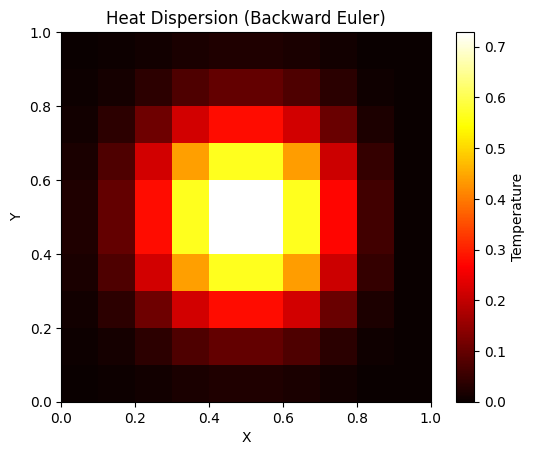

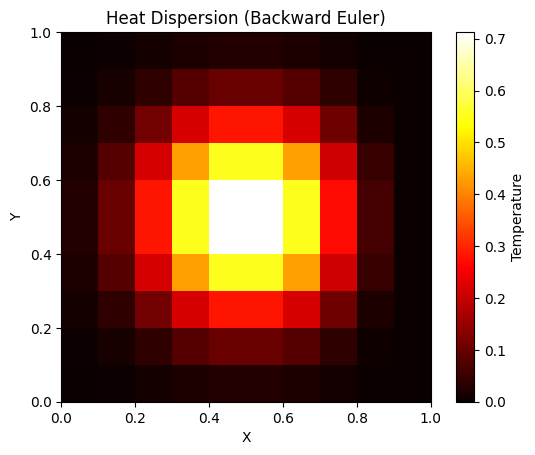

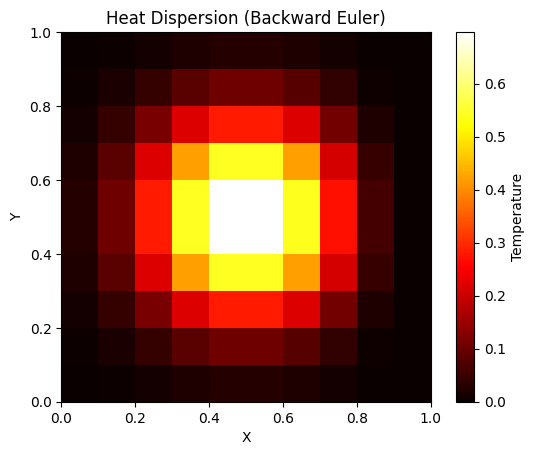

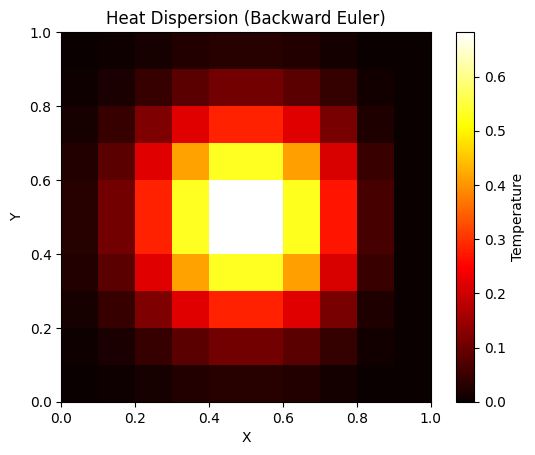

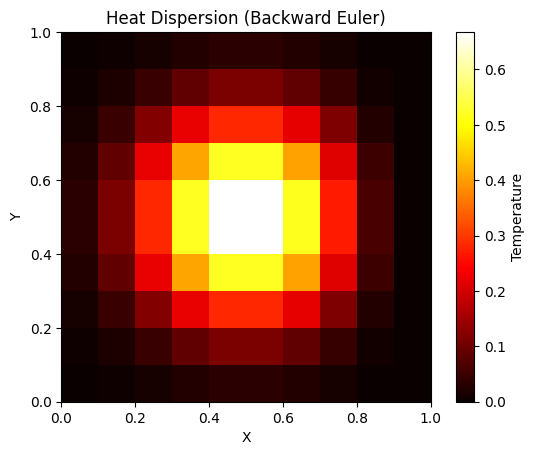

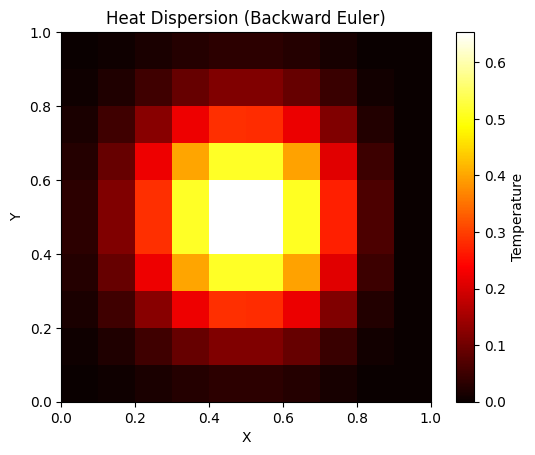

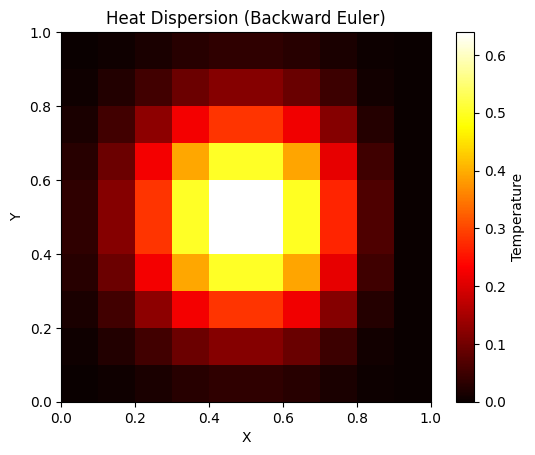

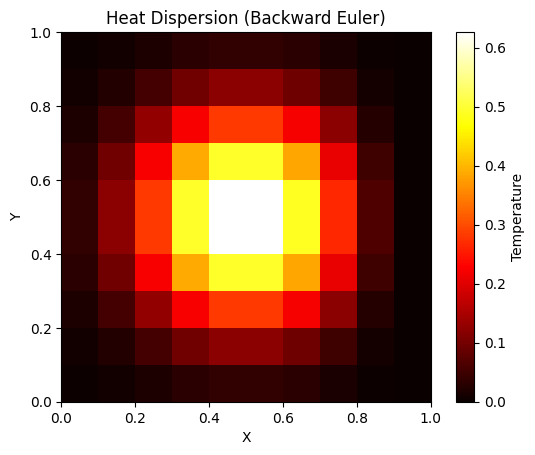

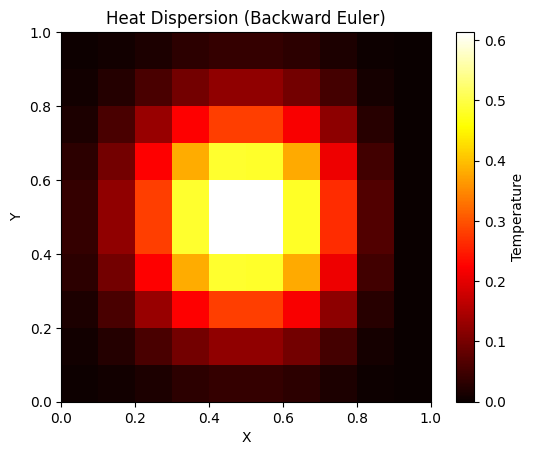

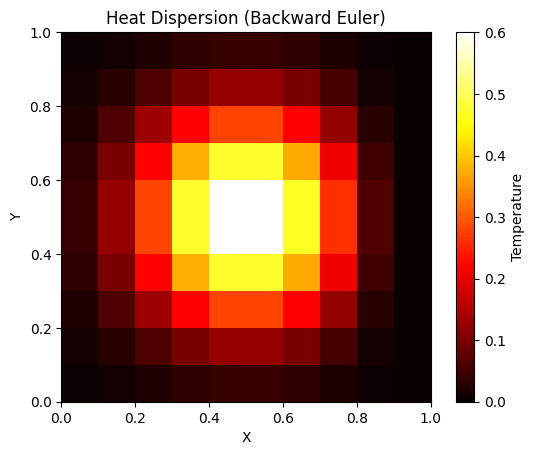

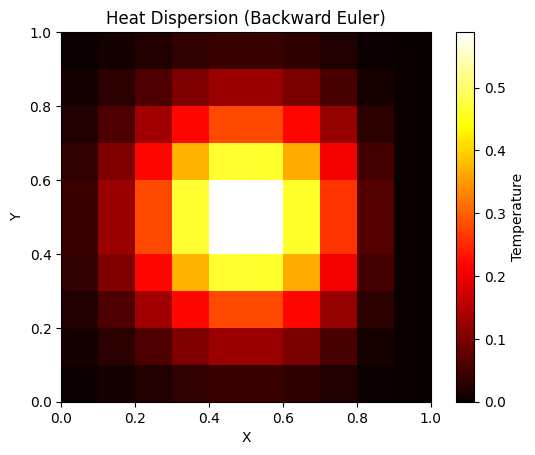

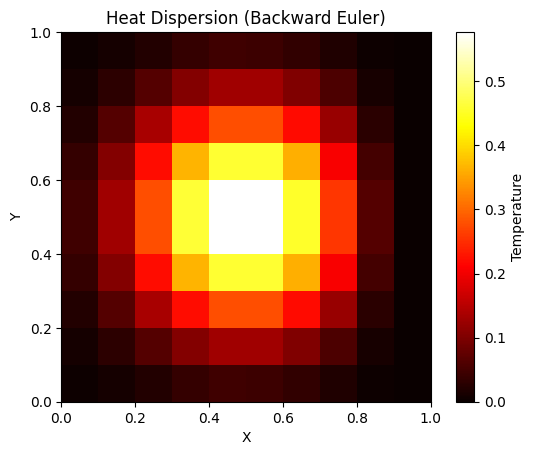

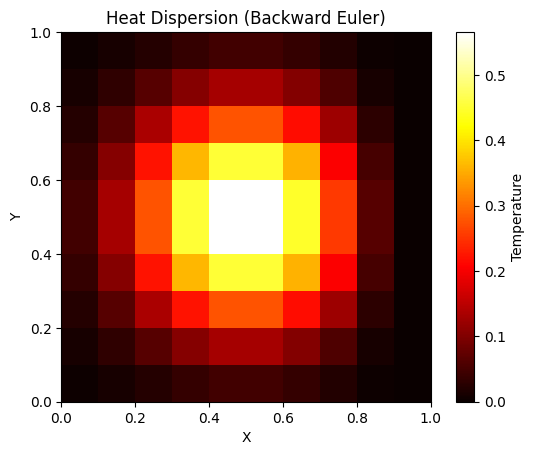

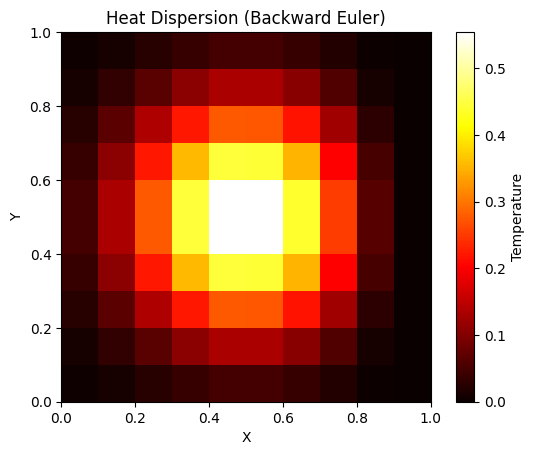

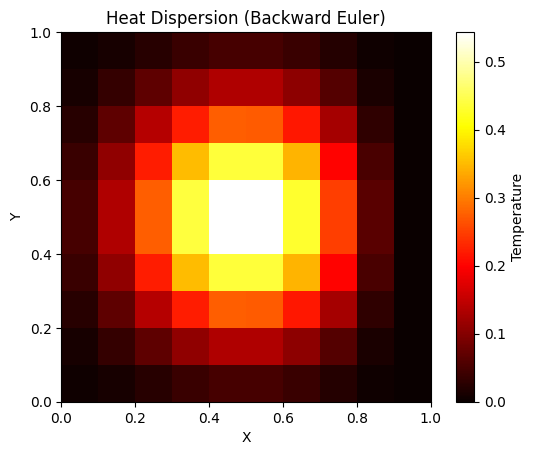

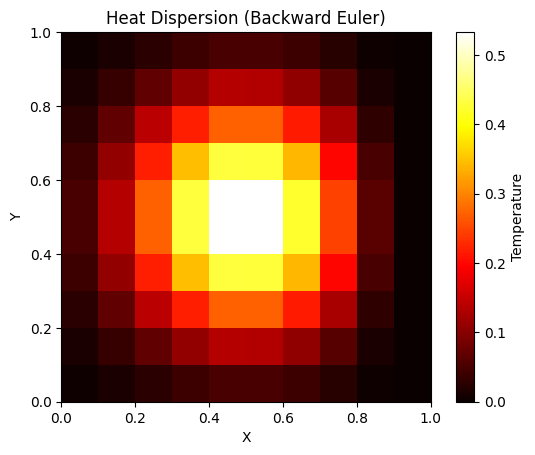

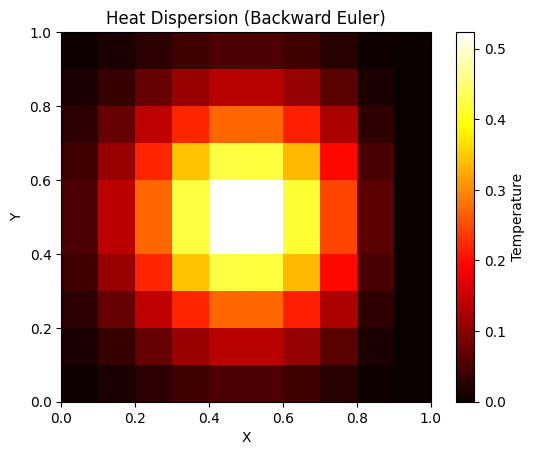

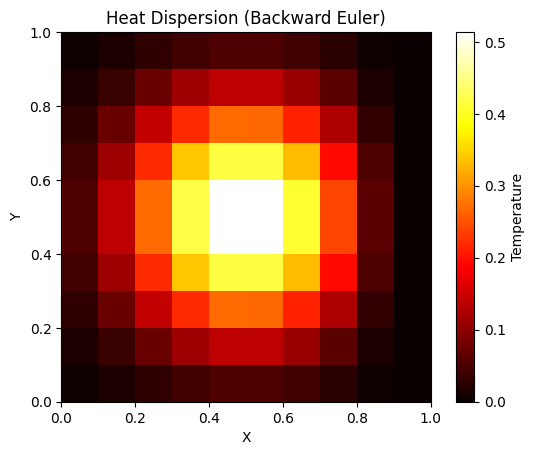

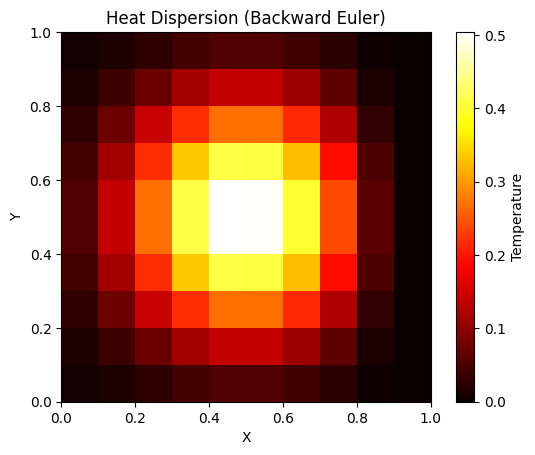

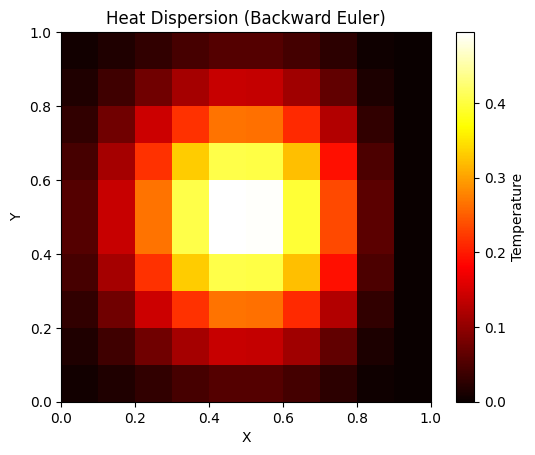

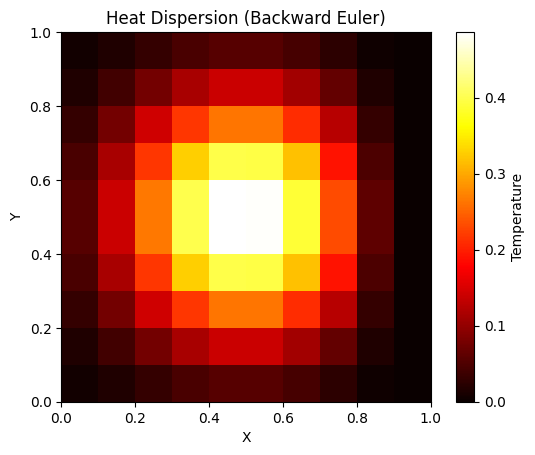

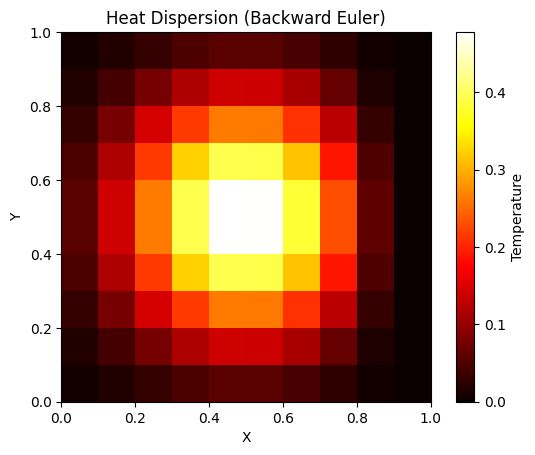

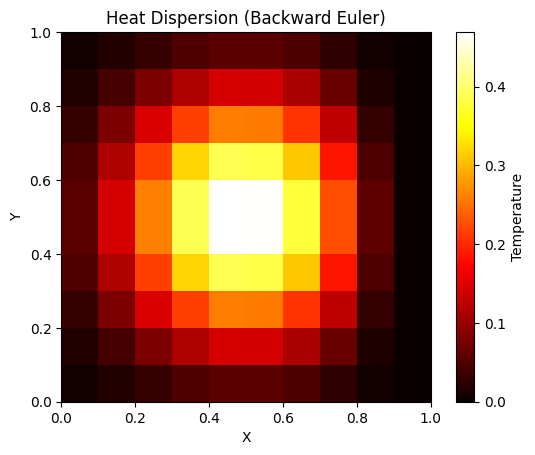

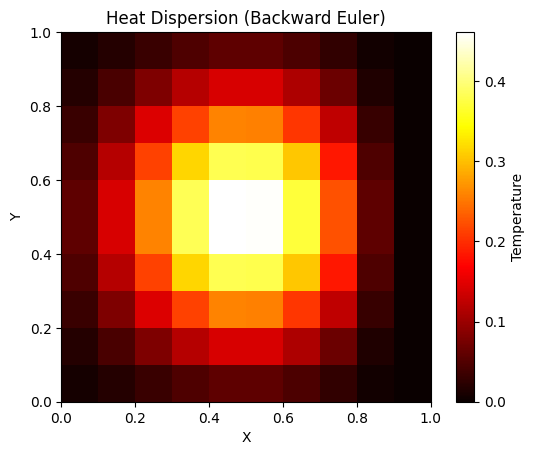

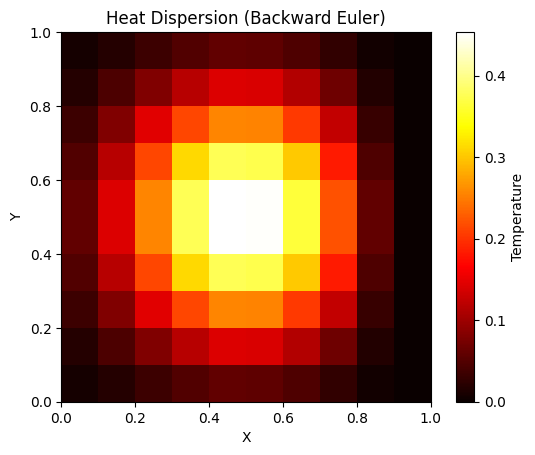

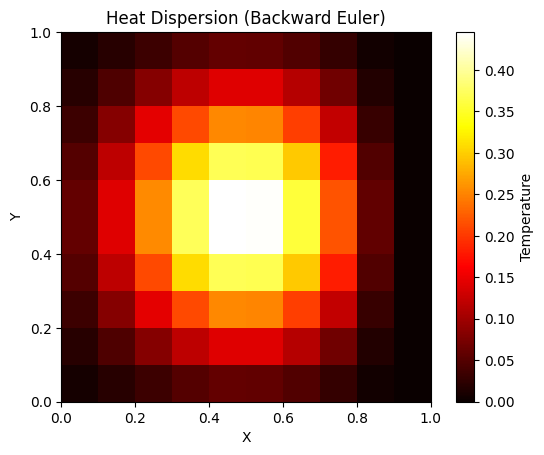

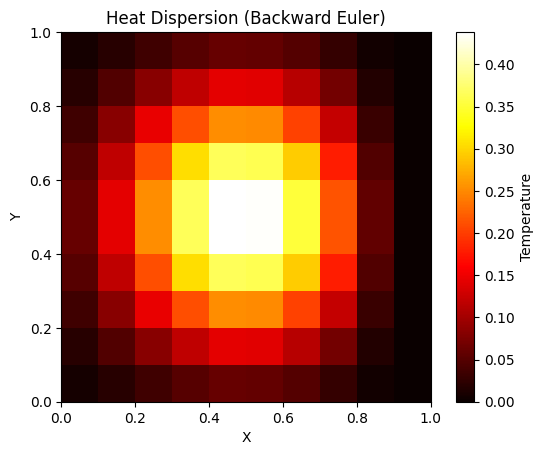

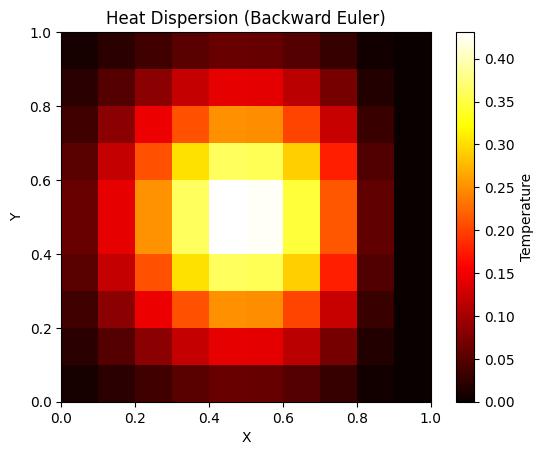

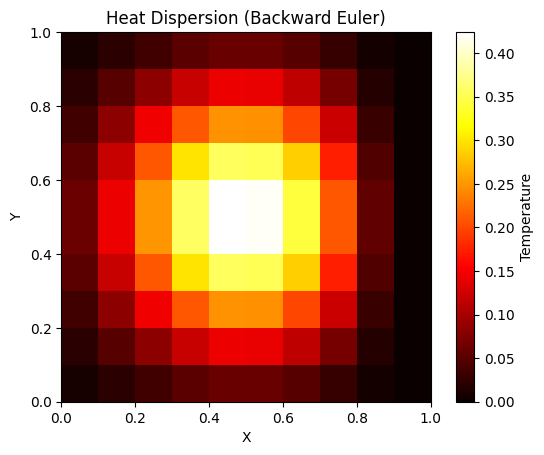

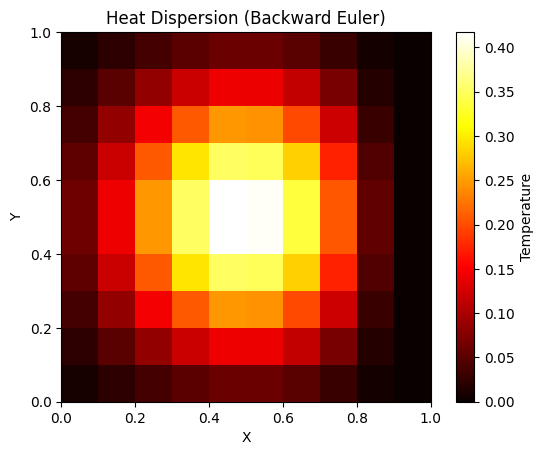

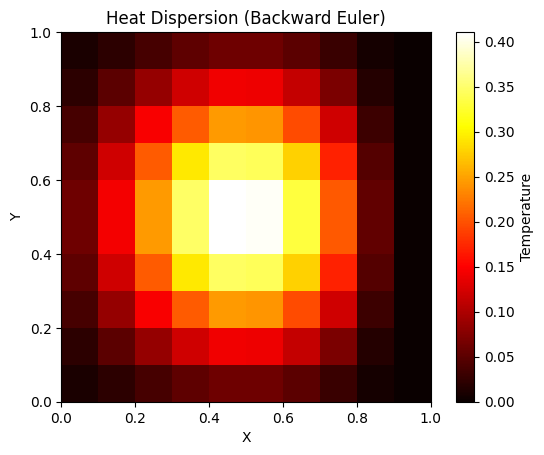

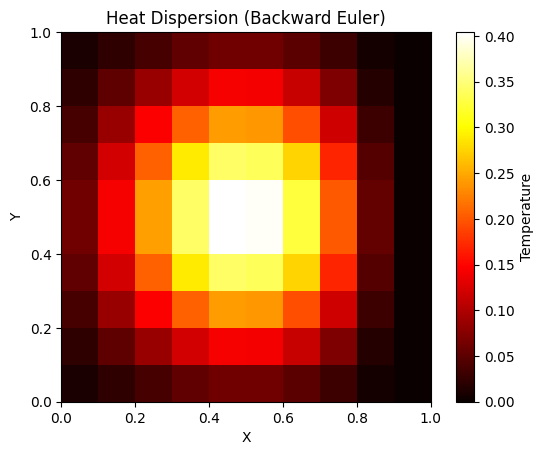

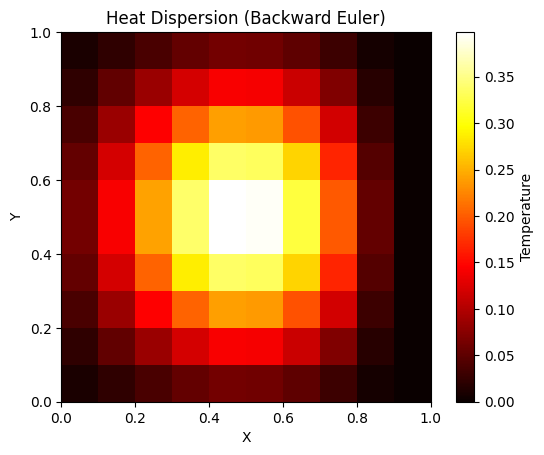

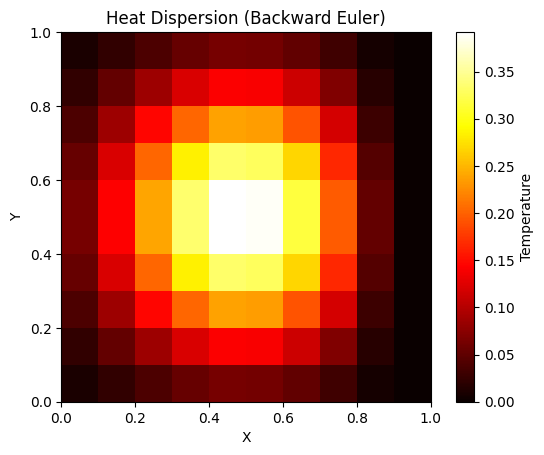

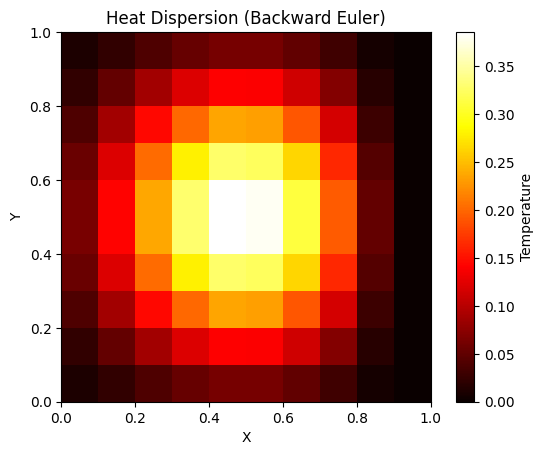

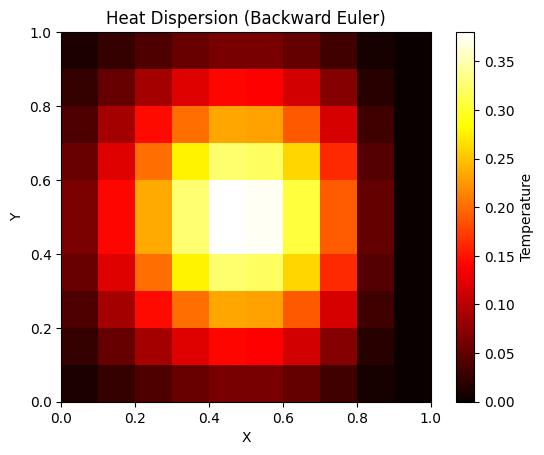

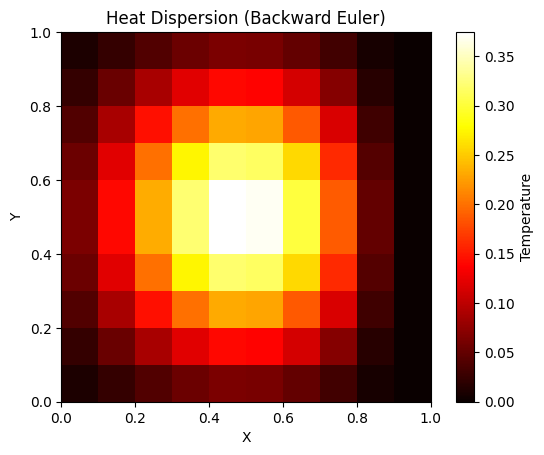

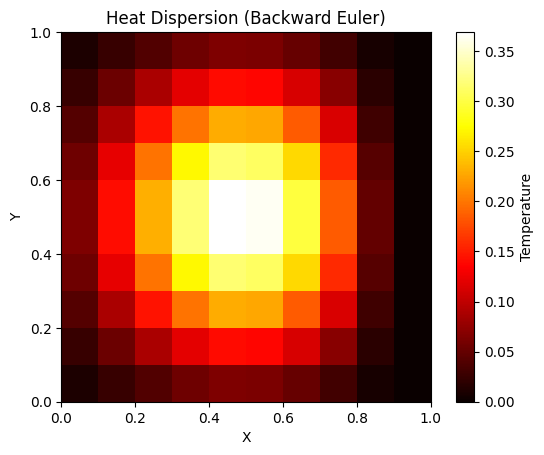

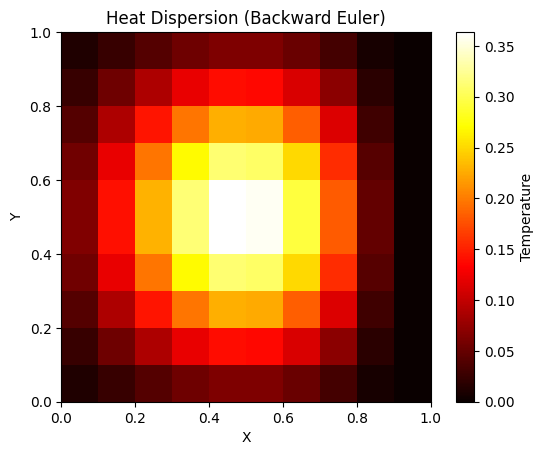

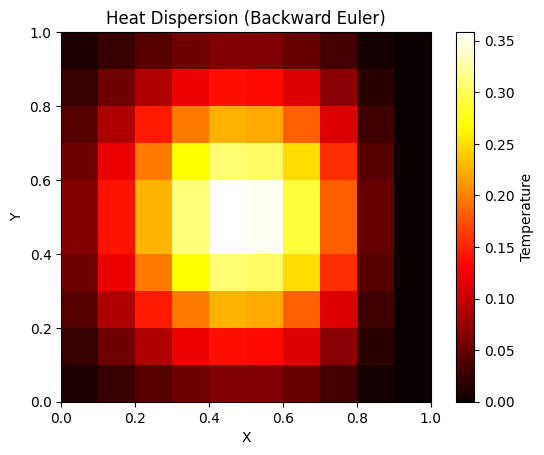

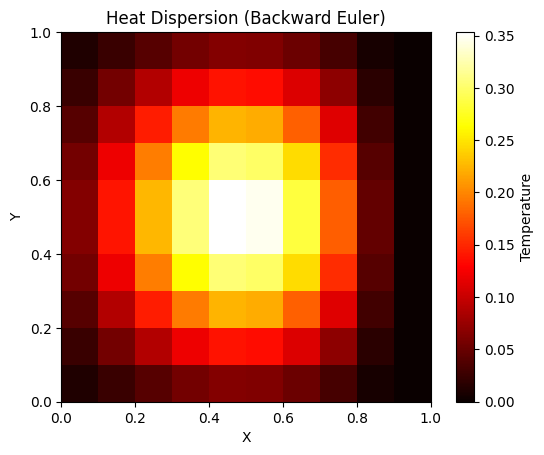

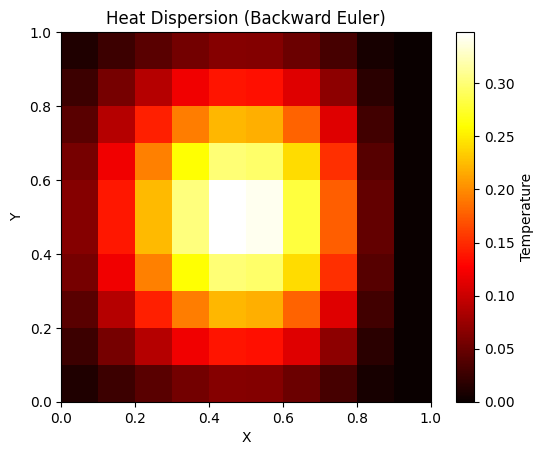

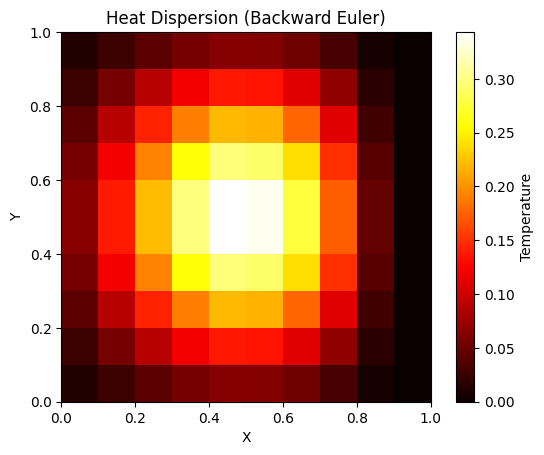

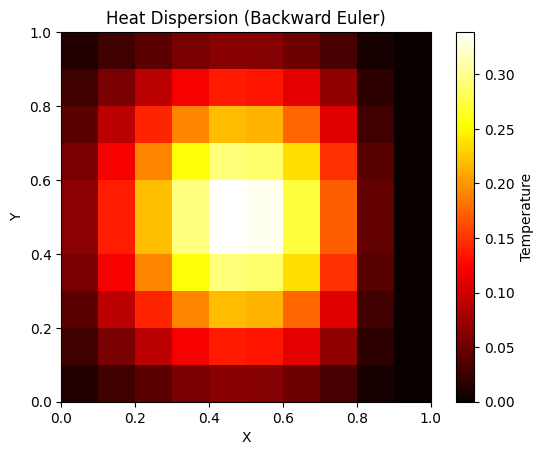

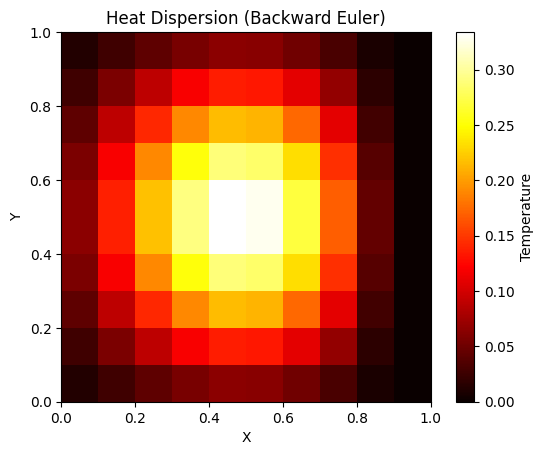

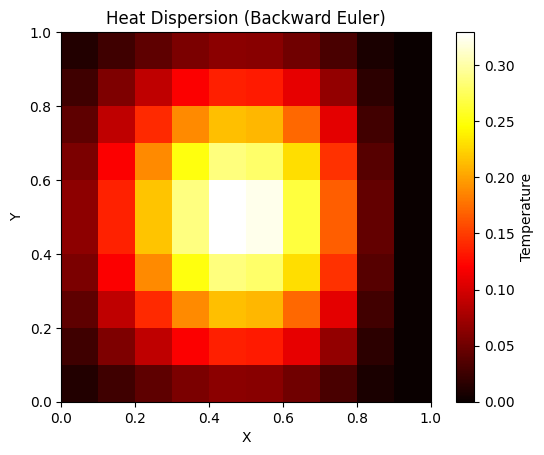

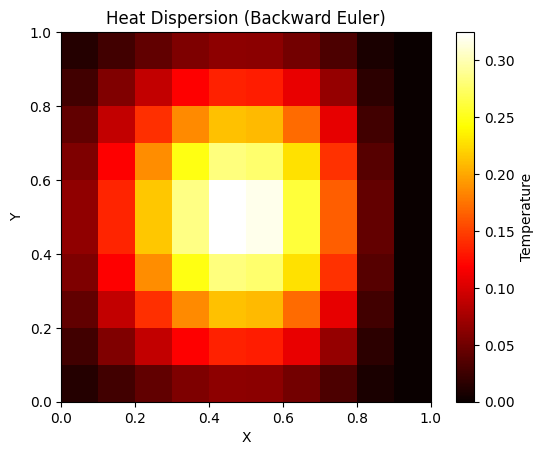

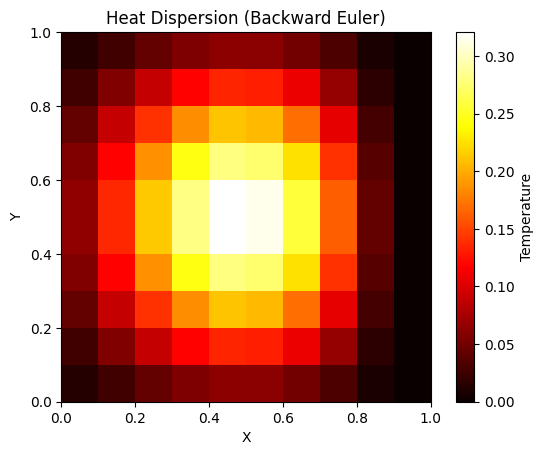

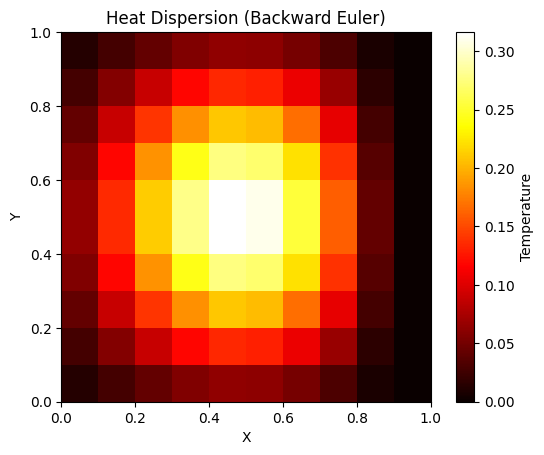

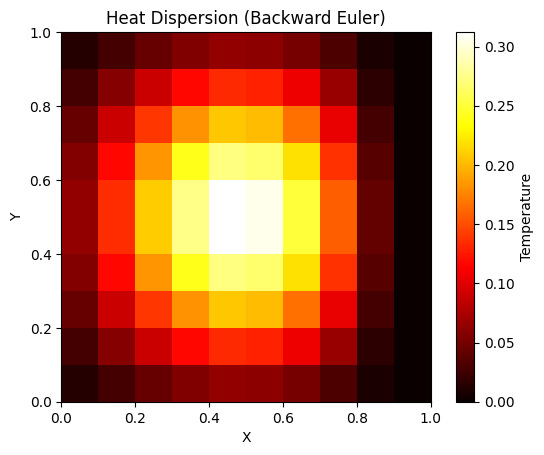

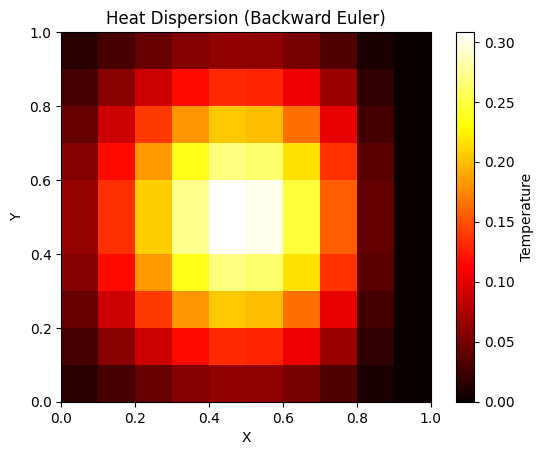

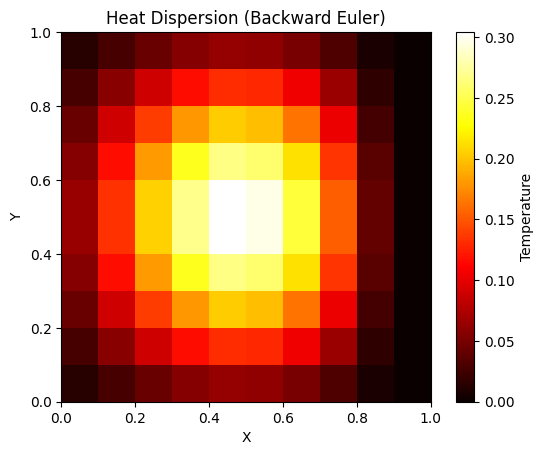

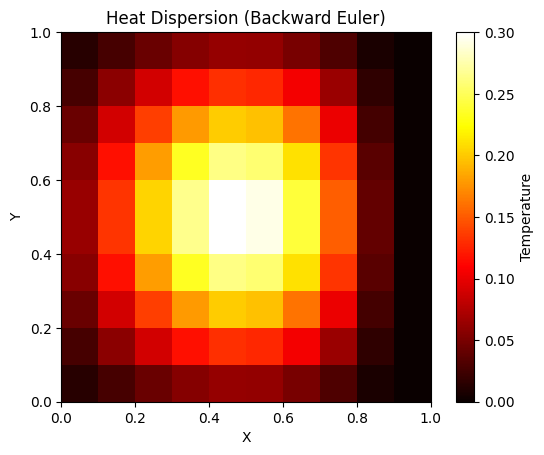

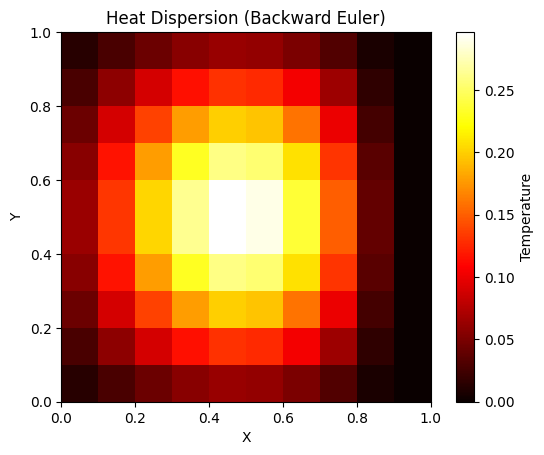

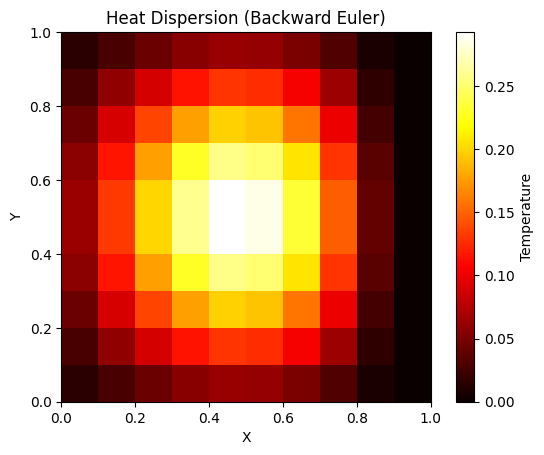

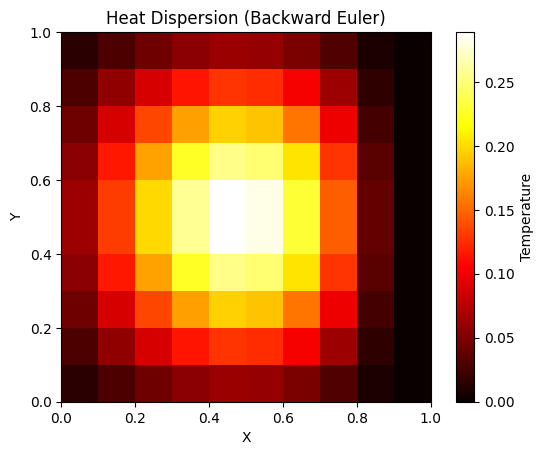

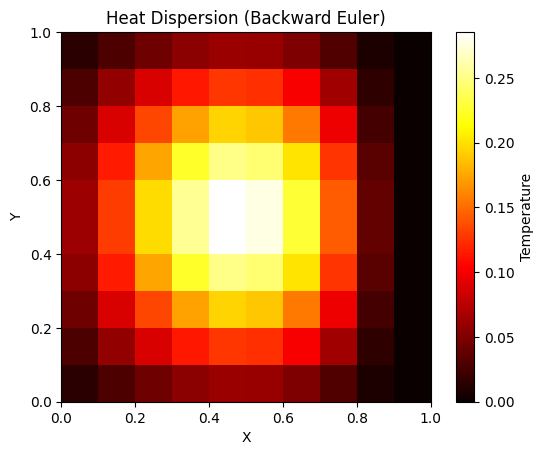

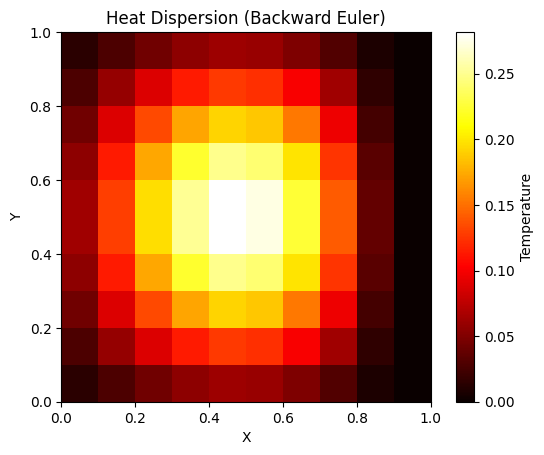

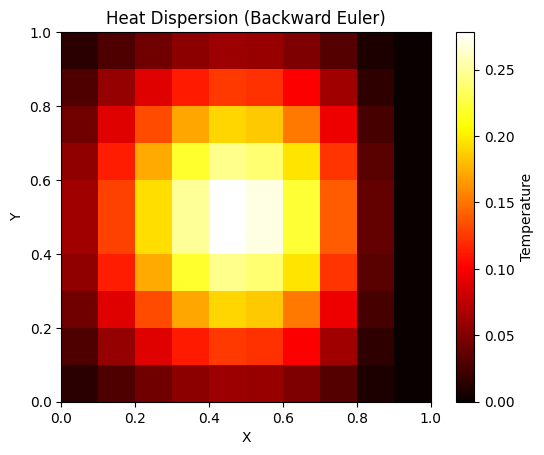

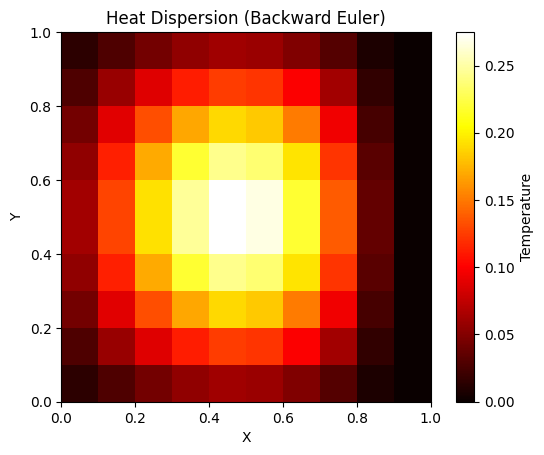

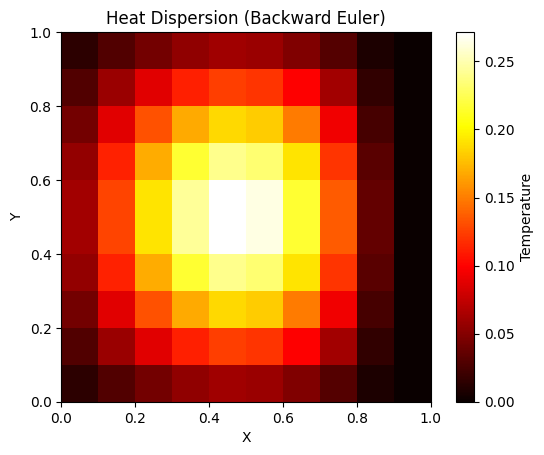

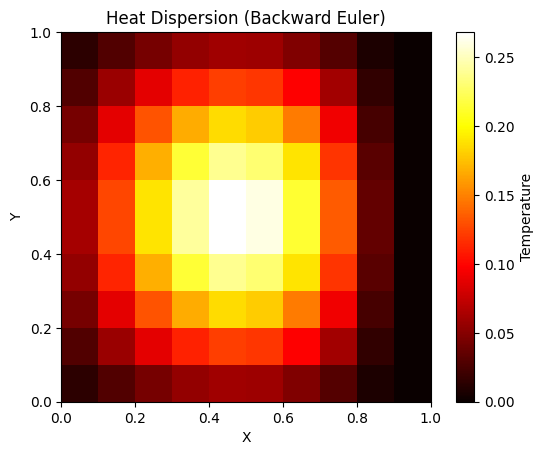

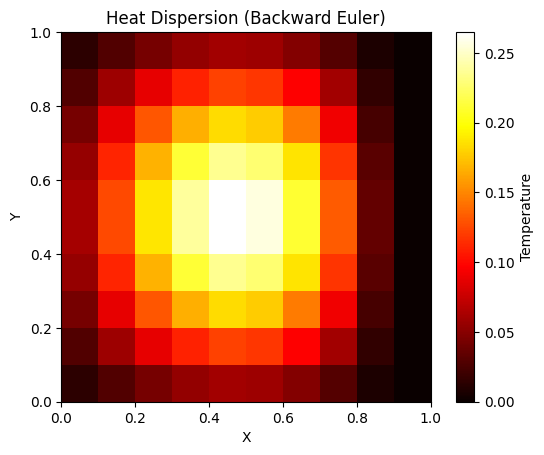

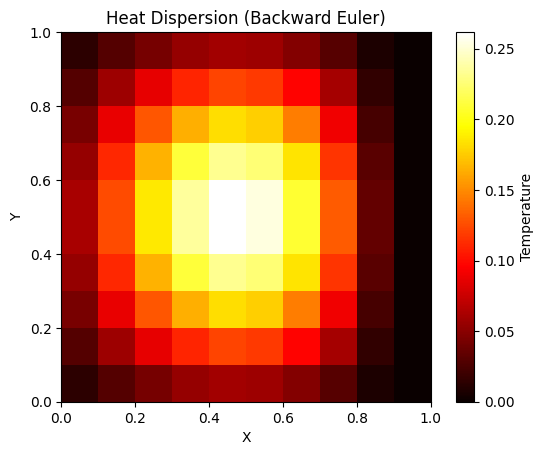

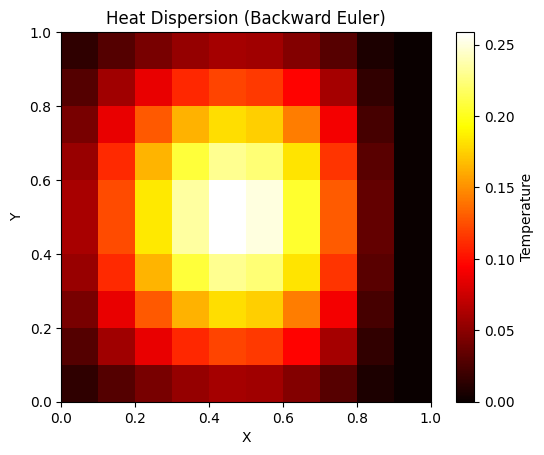

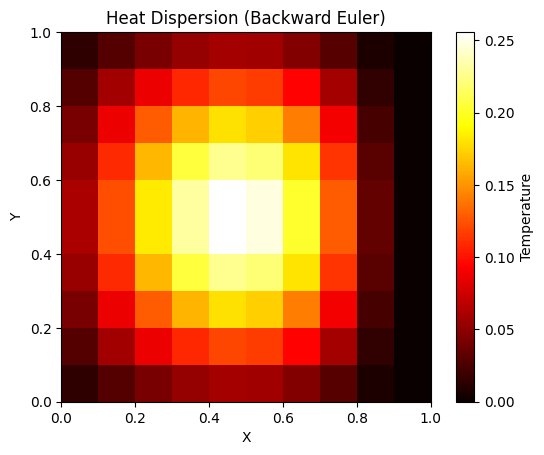

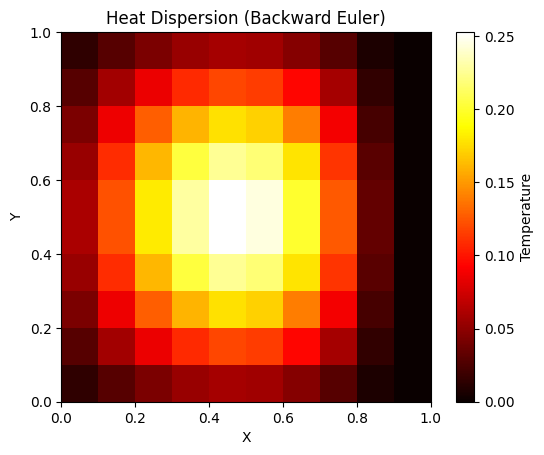

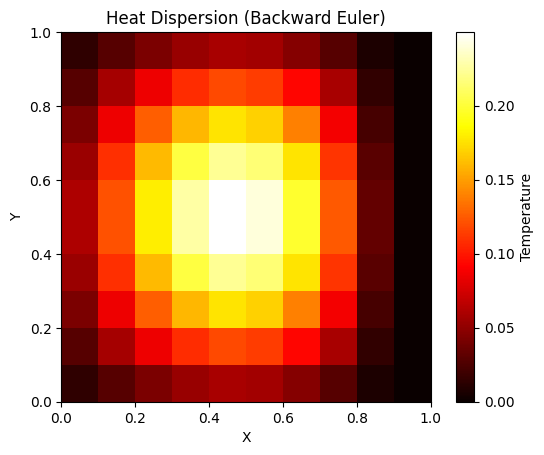

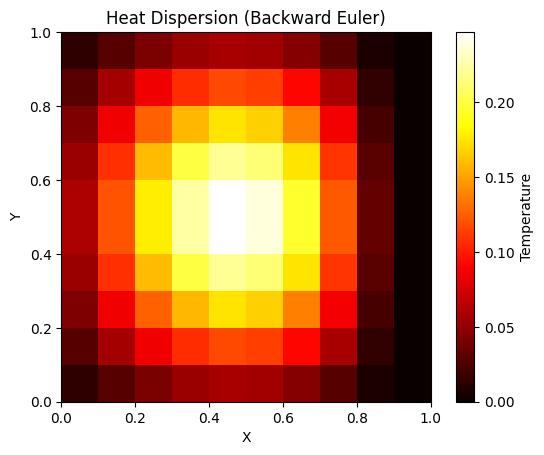

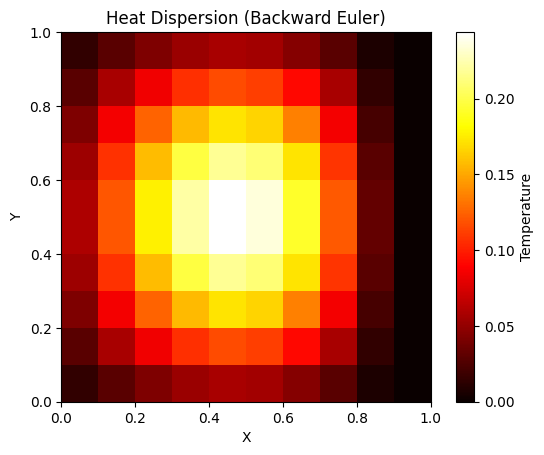

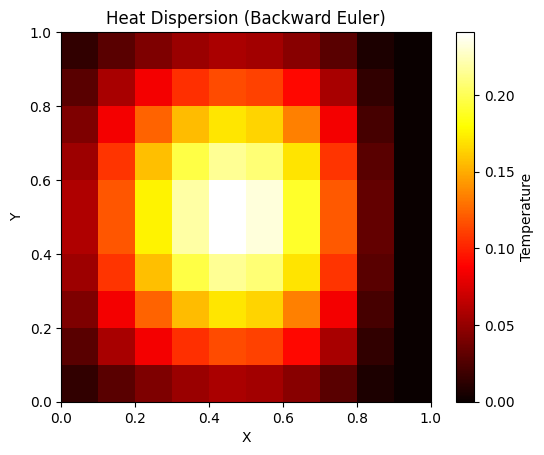

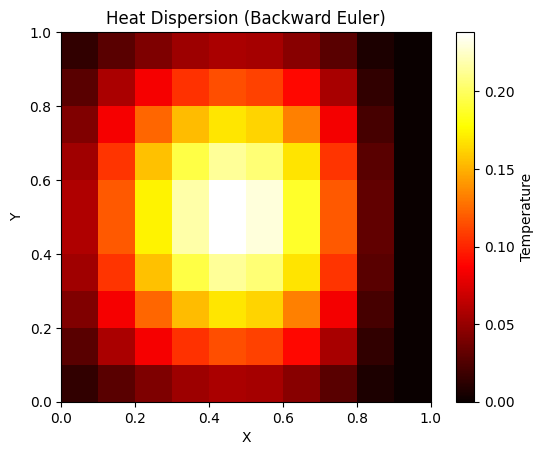

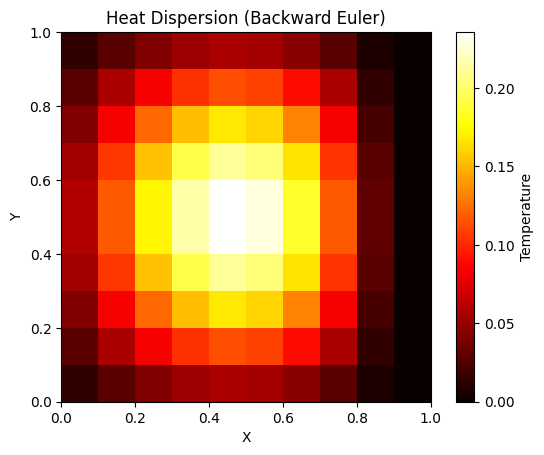

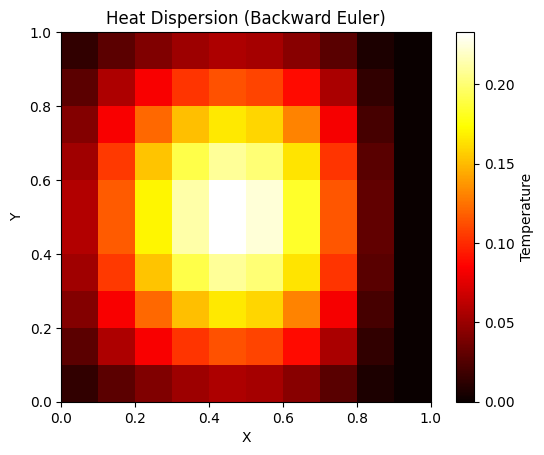

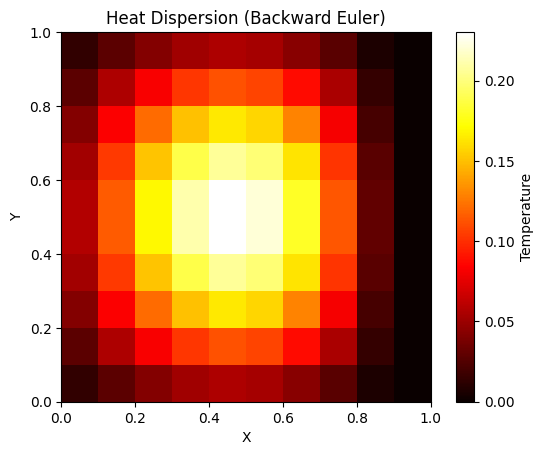

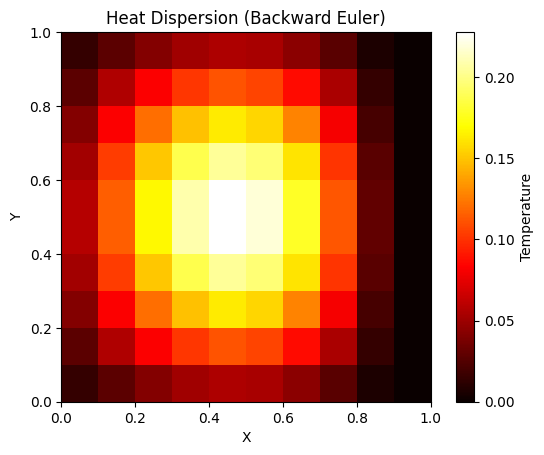

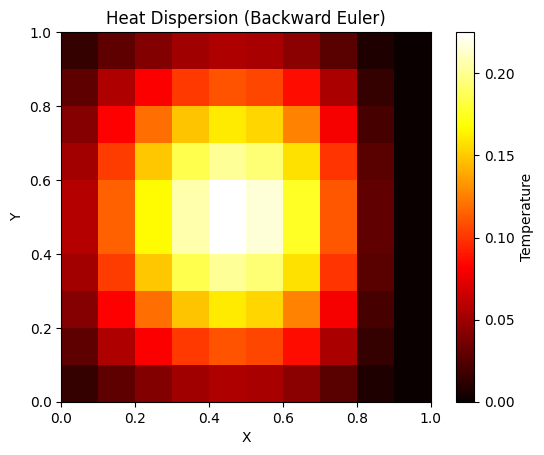

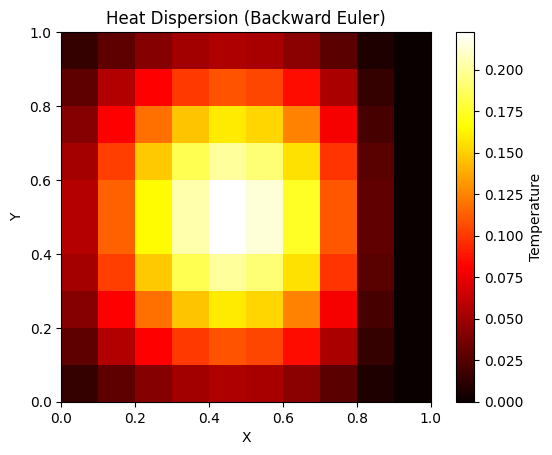

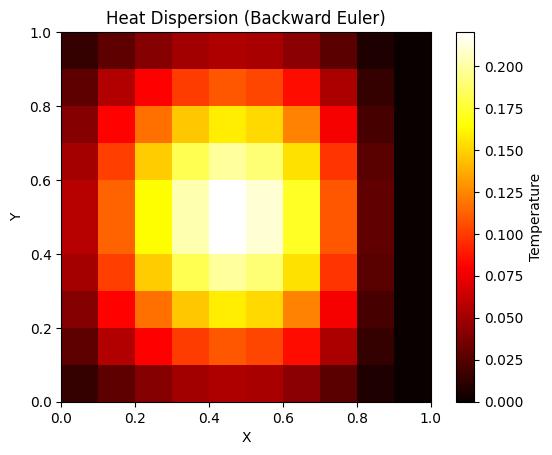

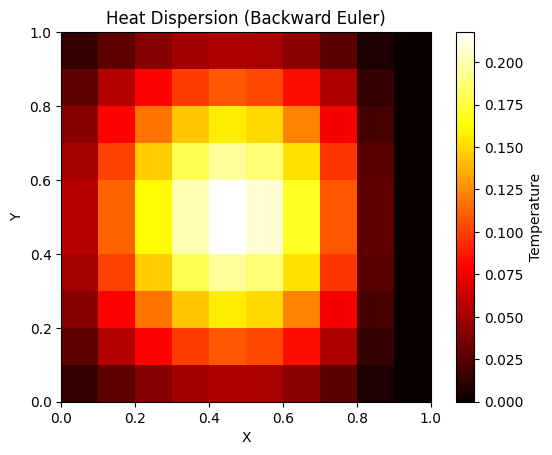

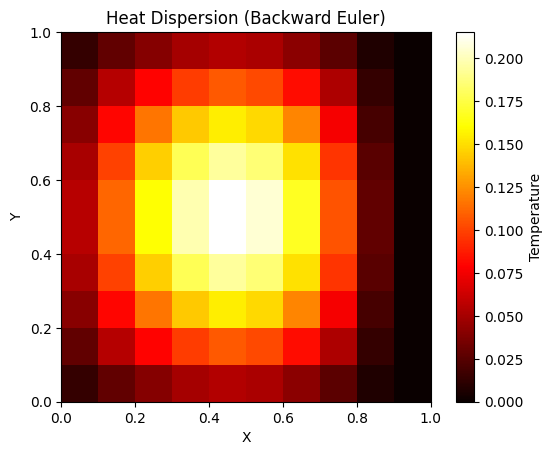

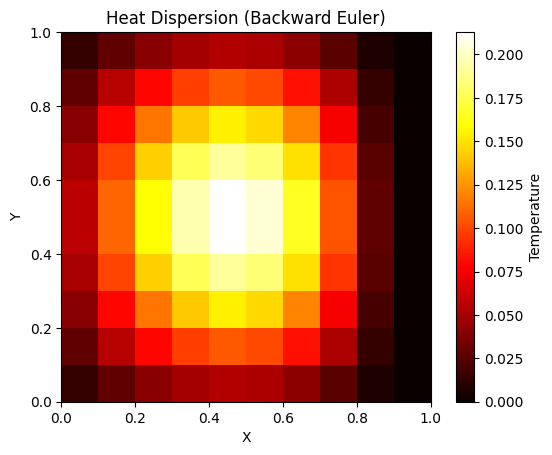

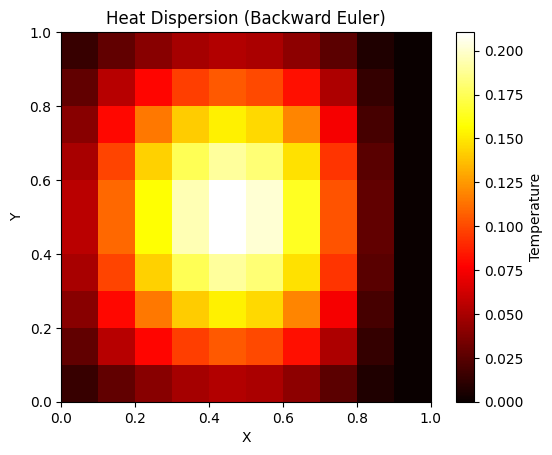

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Define parameters
N = 10  # Number of grid points in each dimension
T = 1.0  # Total time
dt = 0.01  # Time step size
D = 0.1  # Diffusion coefficient

# Initialize grid with given initial condition
grid = np.zeros((N, N))
# Given initial condition
initial_condition = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                               [0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
                               [0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
                               [0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
                               [0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
                               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

grid = initial_condition

# Set up coefficient matrix for implicit scheme
alpha = D * dt / (2 * (1 / N) ** 2)
diagonal = np.ones(N**2) * (1 + 4 * alpha)
off_diagonals = np.ones(N**2 - 1) * (-alpha)
off_diagonals[N-1::N] = 0  # Zero out elements at the boundaries
off_diagonals[N-2::N] = 0  # Zero out elements at the boundaries
A = diags([off_diagonals, off_diagonals, diagonal, off_diagonals, off_diagonals],
          [-N, N, 0, -1, 1], shape=(N**2, N**2)).toarray()

# Time-stepping loop
num_steps = int(T / dt)
for _ in range(num_steps):
    # Flatten grid for linear algebra
    b = grid.flatten()
    # Solve linear system using sparse solver
    grid = spsolve(A, b).reshape((N, N))

    # Plot the result
    plt.imshow(grid, cmap='hot', origin='lower', extent=[0, 1, 0, 1])
    plt.colorbar(label='Temperature')
    plt.title('Heat Dispersion (Backward Euler)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
D = 0.1  # Diffusion coefficient
L = 1.0  # Length of the domain
N = 10   # Number of grid points in each dimension
T = 1.0  # Total time
dt = 0.01  # Time step
dx = L / (N - 1)  # Grid spacing
timesteps = int(T / dt)  # Number of time steps

# Initial condition
initial_condition = np.zeros((N, N))
initial_condition[N//2, N//2] = 1.0  # Center of the grid is heated

# Backward Euler method
def backward_euler(diff_coeff, grid, dt, dx, timesteps):
    u = np.copy(grid)
    alpha = diff_coeff * dt / (dx**2)
    
    for _ in range(timesteps):
        u[1:-1, 1:-1] += alpha * (u[2:, 1:-1] - 2*u[1:-1, 1:-1] + u[:-2, 1:-1] + 
                                   u[1:-1, 2:] - 2*u[1:-1, 1:-1] + u[1:-1, :-2])
    return u

# Crank-Nicolson method
def crank_nicolson(diff_coeff, grid, dt, dx, timesteps):
    u = np.copy(grid)
    alpha = 0.5 * diff_coeff * dt / (dx**2)
    A = np.eye(N-2) * (1 + 2*alpha)
    B = np.eye(N-2, k=-1) * -alpha
    C = np.eye(N-2, k=1) * -alpha
    M = A + B + C
    Minv = np.linalg.inv(M)
    
    for _ in range(timesteps):
        b = u[1:-1, 1:-1] + 0.5 * alpha * (u[2:, 1:-1] - 2*u[1:-1, 1:-1] + u[:-2, 1:-1] +
                                            u[1:-1, 2:] - 2*u[1:-1, 1:-1] + u[1:-1, :-2])
        u[1:-1, 1:-1] = np.dot(Minv, b.flatten()).reshape((N-2, N-2))
    return u

# Solve using Backward Euler
solution_be = backward_euler(D, initial_condition, dt, dx, timesteps)

# Solve using Crank-Nicolson
solution_cn = crank_nicolson(D, initial_condition, dt, dx, timesteps)

# Plot results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(solution_be, cmap='hot', origin='lower', extent=[0, L, 0, L])
plt.colorbar(label='Temperature')
plt.title('Backward Euler Method')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1, 2, 2)
plt.imshow(solution_cn, cmap='hot', origin='lower', extent=[0, L, 0, L])
plt.colorbar(label='Temperature')
plt.title('Crank-Nicolson Method')
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.show()


ValueError: shapes (8,8) and (64,) not aligned: 8 (dim 1) != 64 (dim 0)